In [1]:
import pandas as pd
import numpy as np
import seaborn
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import geopandas
from numpy import absolute
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from scipy.stats import linregress
from shapely.geometry import box
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv').drop_duplicates()
validation = pd.read_csv('validation.csv').drop_duplicates()
validation = validation.reset_index()

#https://towardsdatascience.com/error-in-variables-models-deming-regression-11ca93b6e138
x = train['LS_Temp']
y = train['Temp']
x_mean = x.mean()
y_mean = y.mean()

s_xy = ((x - x.mean()) * (y - y.mean())).sum() 
s_xx = ((x - x.mean())**2).sum()
s_yy = ((y - y.mean())**2).sum()

delta = 1/4

deming_slope = (s_yy - delta*s_xx + np.sqrt((s_yy - delta*s_xx)**2 + 4*delta*s_xy**2)) / (2*s_xy)
deming_intercept = y_mean - x_mean*deming_slope

print(deming_slope, deming_intercept)

validation['Predicted_Temp'] = (deming_slope*validation['LS_Temp'])+deming_intercept

0.9670551603096057 0.34079984590076506


In [4]:
all = pd.concat([train, validation])
all.groupby(['sat']).size()

sat
LC08    4733
LE07    9564
LT05    4947
dtype: int64

In [5]:
print('number of matchup', all.shape)

number of matchup (19244, 14)


In [14]:
all.year.describe()

count    19244.000000
mean      2011.561266
std          6.724421
min       1986.000000
25%       2006.000000
50%       2012.000000
75%       2017.000000
max       2022.000000
Name: year, dtype: float64

In [6]:
#with Calibration
print(r2_score(validation['Temp'],validation['Predicted_Temp']))
print(mean_absolute_error(validation['Temp'],validation['Predicted_Temp']))
print(mean_absolute_percentage_error(validation['Temp'],validation['Predicted_Temp']))
print(mean_squared_error(validation['Temp'],validation['Predicted_Temp'], squared=False))
slope, intercept, r_value, p_value, std_err = linregress(validation['Predicted_Temp'],validation['Temp'])
print(slope)

0.9190130957698868
1.6301295893061436
0.10060038876690255
2.2658954437610963
0.9397026534550378


In [5]:
#without Calibration
print(r2_score(validation['Temp'],validation['LS_Temp']))
print(mean_absolute_error(validation['Temp'],validation['LS_Temp']))
print(mean_absolute_percentage_error(validation['Temp'],validation['LS_Temp']))
print(mean_squared_error(validation['Temp'],validation['LS_Temp'], squared=False))
slope, intercept, r_value, p_value, std_err = linregress(validation['LS_Temp'],validation['Temp'])
print(slope)

0.9109711987156465
1.7173892249895808
0.10646924522940703
2.375733545737678
0.9087443001803237


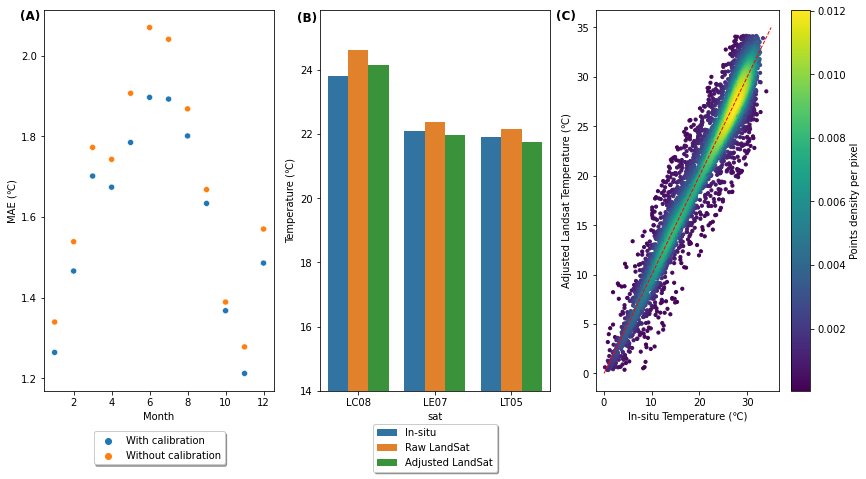

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(14,7))

validation['diff_temp'] = np.abs(validation['Temp']-validation['Predicted_Temp'])
by_month_cali = validation.groupby(['month'])['diff_temp'].mean().reset_index()
by_month_cali['type'] = 'With calibration'

validation['diff_temp'] = np.abs(validation['Temp']-validation['LS_Temp'])
by_month_without_cali = validation.groupby(['month'])['diff_temp'].mean().reset_index()
by_month_without_cali['type'] = 'Without calibration'

all = pd.concat([by_month_cali,by_month_without_cali  ])
all['MAE (℃)'] = all['diff_temp']
all['Month'] = all['month']

sns.scatterplot(ax = axes[0], data=all, x="Month", y="MAE (℃)", hue="type")
axes[0].legend(loc='center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=1)
axes[0].text(-0.8, 2.09, '(A)', fontsize=12,weight="bold")

validation1 = validation[['sat', 'LS_Temp', 'Temp','Predicted_Temp']]
validation1['In-situ'] = validation['Temp']
validation1['Raw LandSat']=validation['LS_Temp']
validation1['Adjusted LandSat']=validation['Predicted_Temp']

mean_temp = validation1.groupby('sat')['In-situ','Raw LandSat','Adjusted LandSat'].median().reset_index()
mean_temp = pd.melt(mean_temp, id_vars='sat', value_vars=['In-situ','Raw LandSat','Adjusted LandSat'])
mean_temp['Temperature (℃)'] = mean_temp['value']

sns.barplot(ax=axes[1], data=mean_temp, x="sat", y="Temperature (℃)", hue='variable')
axes[1].set(ylim=(14, None))
axes[1].legend(loc='center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=1)

axes[1].text(-0.8, 25.5, '(B)', fontsize=12,weight="bold")
axes[2].text(-10, 35.8, '(C)', fontsize=12,weight="bold")
from scipy.stats import gaussian_kde
a =validation['Temp'].reset_index()['Temp']
b = validation['Predicted_Temp'].reset_index()['Predicted_Temp']
xy = np.vstack([a,b])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
c = axes[2].scatter(x, y, c=z, s=10)
axes[2].plot([0, 35], [0, 35], linewidth=1, linestyle='--', c='red')

axes[2].set_xlabel("In-situ Temperature (℃)")
axes[2].set_ylabel("Adjusted Landsat Temperature (℃)")

fig.colorbar(c, label='Points density per pixel')
plt.show()
fig.tight_layout()
fig.savefig('1.png', dpi=fig.dpi, bbox_inches='tight')

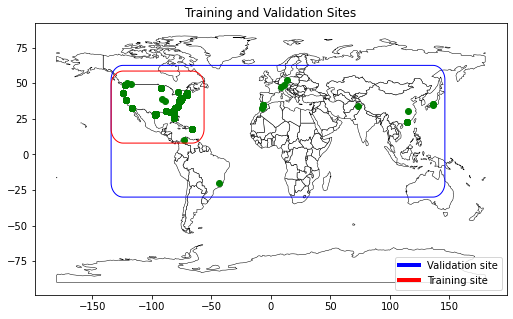

In [89]:
#
import matplotlib as mpl
from matplotlib import cycler
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

g_validation = geopandas.GeoDataFrame(
    validation, geometry=geopandas.points_from_xy(validation.long, validation.lat))

g_train = geopandas.GeoDataFrame(
    train, geometry=geopandas.points_from_xy(train.long, train.lat))

g_validation_box = box(*g_validation.total_bounds).buffer(10)
g_validation_box= geopandas.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[g_validation_box])

g_train_box = box(*g_train.total_bounds).buffer(10)
g_train_box= geopandas.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[g_train_box])

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
world.plot(ax=ax, color='white', edgecolor='black', lw=0.5)

# We can now plot our ``GeoDataFrame``.
g_train.plot(ax=ax, color='green')
g_validation.plot(ax=ax, color='green')

g_validation_box.plot(ax=ax, facecolor="none", 
              edgecolor='blue', lw=1)

g_train_box.plot(ax=ax, facecolor="none", 
              edgecolor='red', lw=1)
plt.title('Training and Validation Sites')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
ax.legend(custom_lines, ['Validation site', 'Training site'], loc='lower right')
plt.show()
fig.savefig('2.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)